In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv


In [2]:
# Veri işleme
import numpy as np
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Makine Öğrenmesi - Temel
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Boyut İndirgeme
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Ağaç Tabanlı Boosting Algoritmaları
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor

# Voting & Stacking (Ensemble)
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    VotingClassifier, VotingRegressor,
    StackingClassifier, StackingRegressor, BaggingClassifier, BaggingRegressor
)

# Hiperparametre Optimizasyonu
import optuna
from optuna.samplers import TPESampler

# Uyarıları gizle
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.width', 1000)

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e3/train.csv')
df.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,42,3,1,Laboratory Technician,4,Married,2596,5099,1,Y,Yes,13,3,2,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,46,3,1,Sales Representative,1,Married,2899,10778,1,Y,No,17,3,4,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,80,3,2,Sales Executive,4,Divorced,4627,16495,0,Y,No,17,3,4,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,40,3,2,Healthcare Representative,1,Married,5347,13384,3,Y,No,14,3,3,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,37,3,5,Manager,1,Single,19033,19805,1,Y,Yes,13,3,3,80,0,31,0,3,31,14,4,10,1


In [4]:
real_test_path = '/kaggle/input/playground-series-s3e3/test.csv'
X_train = df.drop('Attrition', axis=1)
X_test = pd.read_csv(real_test_path)
y_train = df['Attrition']

In [5]:
X_train.drop("Over18", axis=1, inplace=True)
X_test.drop("Over18", axis=1, inplace=True)

In [6]:
rem_cols = ["EmployeeCount", "StandardHours"]

In [7]:
for col in rem_cols:
    X_train.drop(col, axis=1, inplace=True)
    X_test.drop(col, axis=1, inplace=True)

In [8]:
numeric_cols = [
    "Age", "DailyRate", "DistanceFromHome", "HourlyRate",
    "MonthlyIncome", "MonthlyRate", 
    "TotalWorkingYears", "YearsAtCompany", 
    "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"
]

categorical_cols = [
    "BusinessTravel", "Department", "EducationField", "Gender", "EnvironmentSatisfaction", "NumCompaniesWorked",
    "JobRole", "MaritalStatus", "OverTime", "Education", "JobInvolvement", "JobLevel", "JobSatisfaction",
    "PercentSalaryHike", "PerformanceRating", "RelationshipSatisfaction", "StockOptionLevel", "TrainingTimesLastYear",
    "WorkLifeBalance"
]

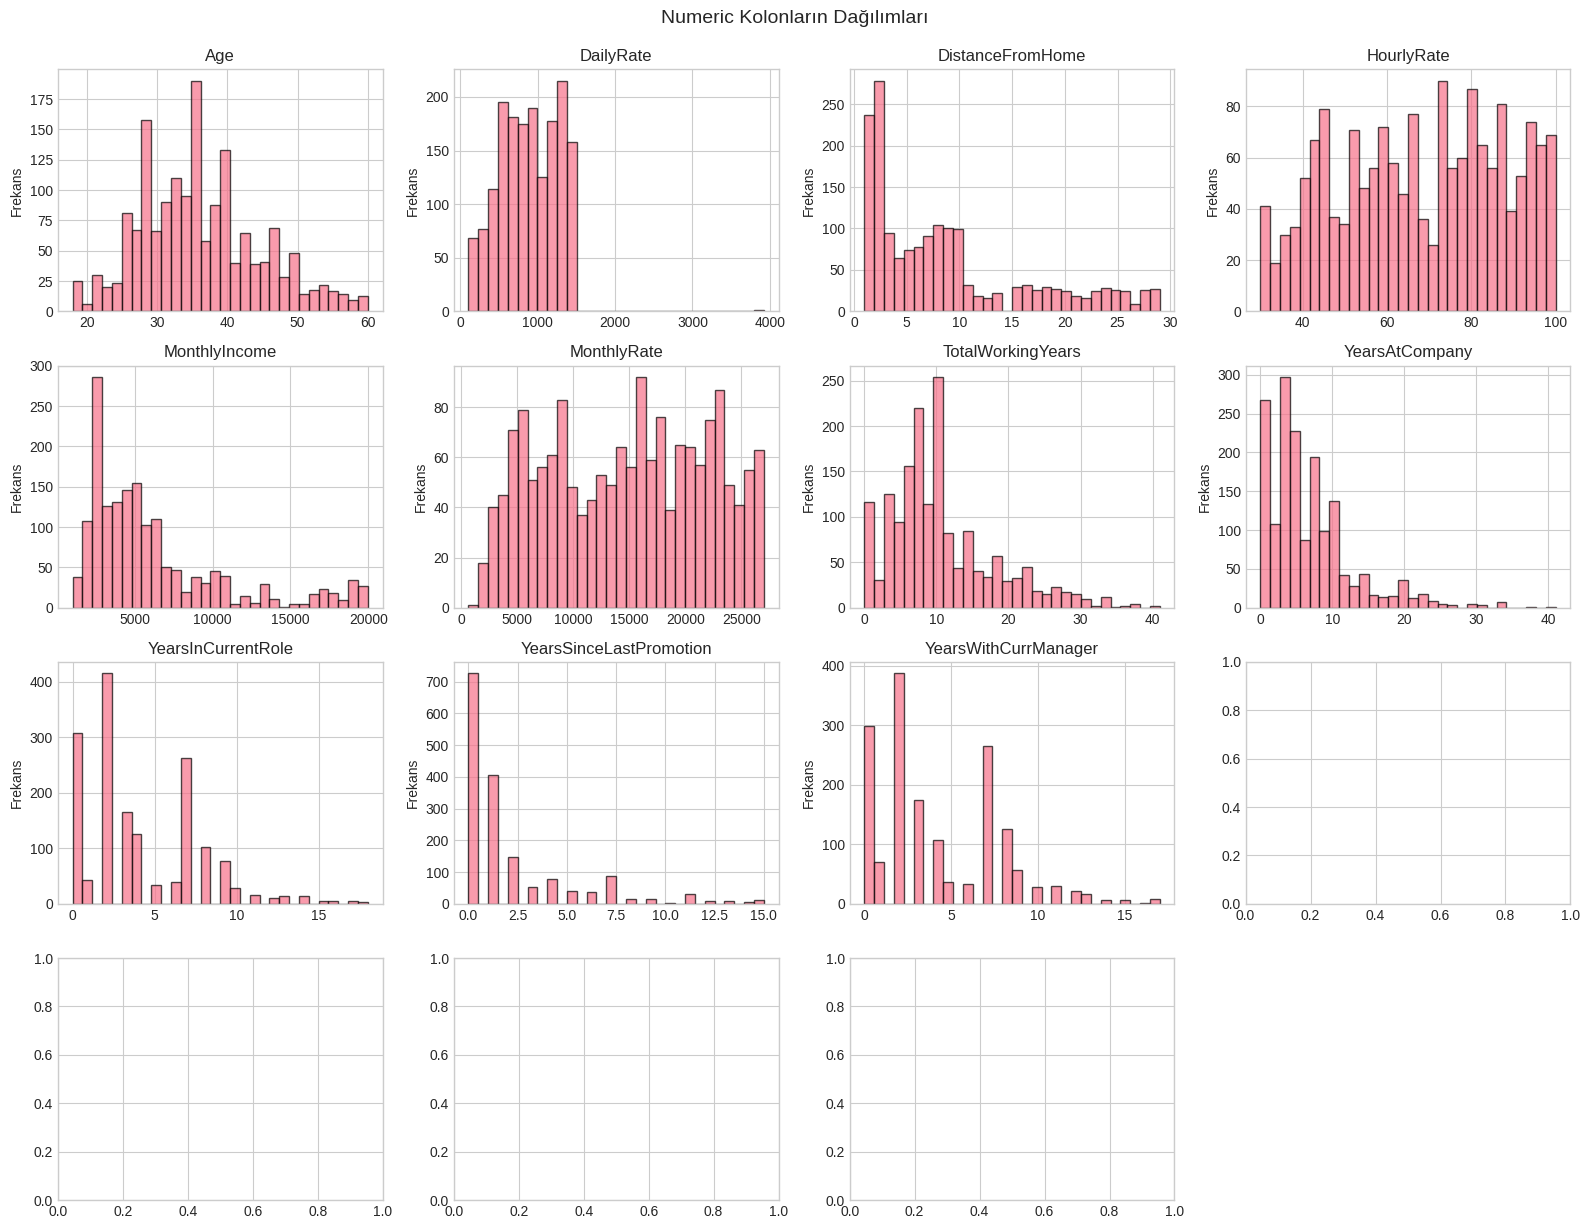

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(X_train[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frekans')

# Fazla subplot'u gizle
axes[-1].set_visible(False)

plt.tight_layout()
plt.suptitle('Numeric Kolonların Dağılımları', y=1.02, fontsize=14)
plt.show()

In [10]:
from scipy.stats import skew

# Çarpıklık değerlerini hesapla
skewness = X_train[numeric_cols].apply(skew).sort_values(ascending=False)

print("Çarpıklık (Skewness) Değerleri:")
print("="*40)
for col, val in skewness.items():
    if abs(val) > 1:
        status = "⚠️ Yüksek çarpıklık"
    elif abs(val) > 0.5:
        status = "⚡ Orta çarpıklık"
    else:
        status = "✅ Normal"
    print(f"{col:30} : {val:>8.4f}  {status}")

print("\n" + "="*40)
print(f"Yüksek çarpıklık (|skew| > 1): {(abs(skewness) > 1).sum()} kolon")
print(f"Orta çarpıklık (|skew| > 0.5): {((abs(skewness) > 0.5) & (abs(skewness) <= 1)).sum()} kolon")

Çarpıklık (Skewness) Değerleri:
YearsSinceLastPromotion        :   2.0789  ⚠️ Yüksek çarpıklık
YearsAtCompany                 :   1.7367  ⚠️ Yüksek çarpıklık
MonthlyIncome                  :   1.5500  ⚠️ Yüksek çarpıklık
TotalWorkingYears              :   1.1442  ⚠️ Yüksek çarpıklık
DistanceFromHome               :   1.0706  ⚠️ Yüksek çarpıklık
YearsInCurrentRole             :   0.9418  ⚡ Orta çarpıklık
YearsWithCurrManager           :   0.8170  ⚡ Orta çarpıklık
Age                            :   0.4537  ✅ Normal
DailyRate                      :   0.1615  ✅ Normal
MonthlyRate                    :  -0.0614  ✅ Normal
HourlyRate                     :  -0.1202  ✅ Normal

Yüksek çarpıklık (|skew| > 1): 5 kolon
Orta çarpıklık (|skew| > 0.5): 2 kolon


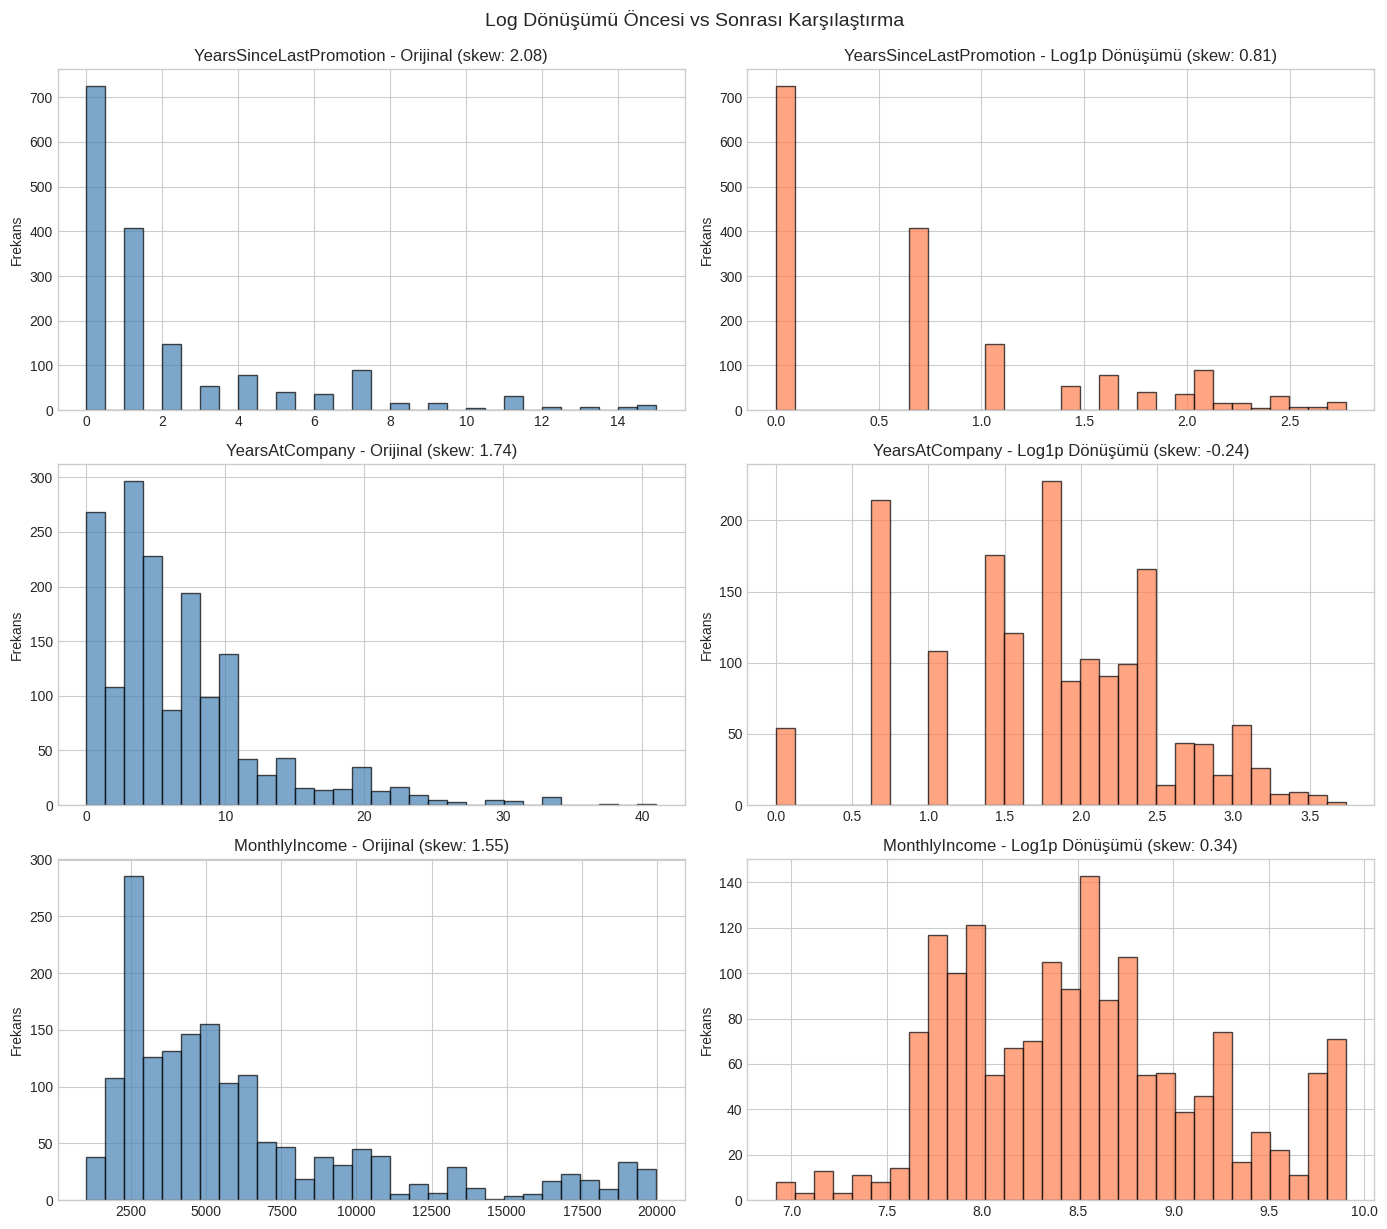

In [11]:
# Log dönüşümü karşılaştırması
skewed_cols = ["YearsSinceLastPromotion", "YearsAtCompany", "MonthlyIncome"]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, col in enumerate(skewed_cols):
    # Orijinal dağılım
    axes[i, 0].hist(X_train[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i, 0].set_title(f'{col} - Orijinal (skew: {skew(df[col]):.2f})')
    axes[i, 0].set_ylabel('Frekans')
    
    # Log dönüşümü (0 değerler için +1 ekliyoruz)
    log_transformed = np.log1p(df[col])
    axes[i, 1].hist(log_transformed, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[i, 1].set_title(f'{col} - Log1p Dönüşümü (skew: {skew(log_transformed):.2f})')
    axes[i, 1].set_ylabel('Frekans')

plt.tight_layout()
plt.suptitle('Log Dönüşümü Öncesi vs Sonrası Karşılaştırma', y=1.02, fontsize=14)
plt.show()

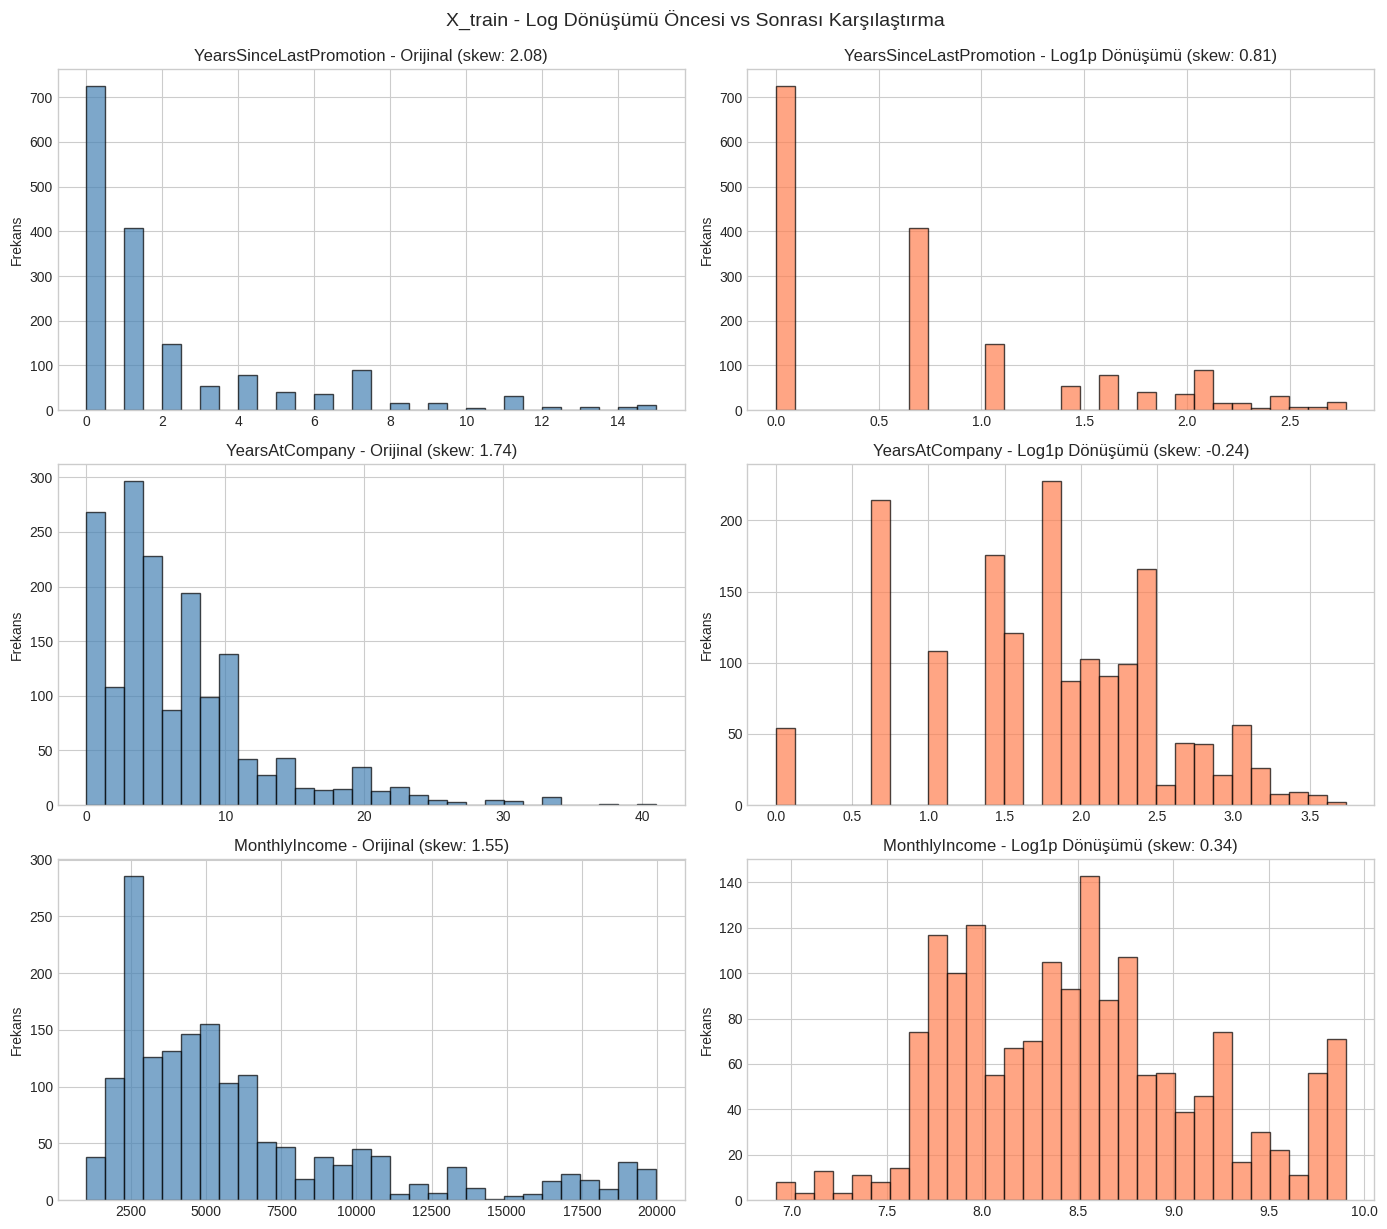

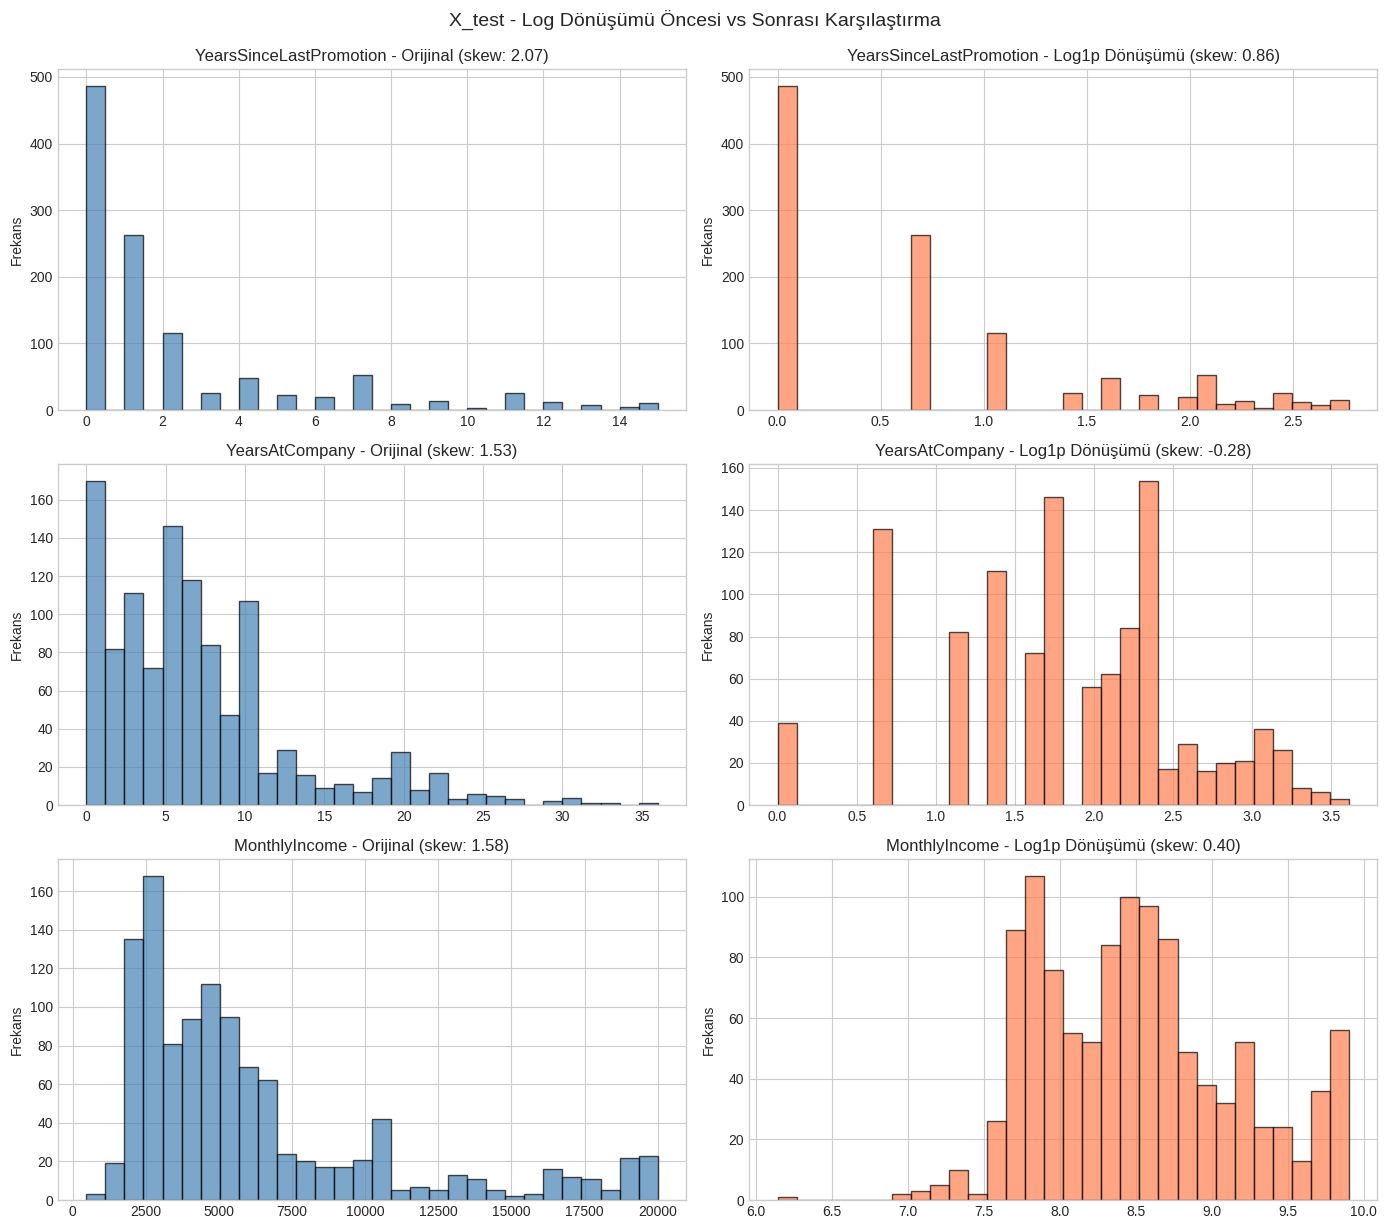

In [12]:
# Log dönüşümü karşılaştırması - X_train ve X_test için
skewed_cols = ["YearsSinceLastPromotion", "YearsAtCompany", "MonthlyIncome"]

# X_train için görselleştirme
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, col in enumerate(skewed_cols):
    # Orijinal dağılım
    axes[i, 0].hist(X_train[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i, 0].set_title(f'{col} - Orijinal (skew: {skew(X_train[col]):.2f})')
    axes[i, 0].set_ylabel('Frekans')
    
    # Log dönüşümü (0 değerler için +1 ekliyoruz)
    log_transformed = np.log1p(X_train[col])
    axes[i, 1].hist(log_transformed, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[i, 1].set_title(f'{col} - Log1p Dönüşümü (skew: {skew(log_transformed):.2f})')
    axes[i, 1].set_ylabel('Frekans')

plt.tight_layout()
plt.suptitle('X_train - Log Dönüşümü Öncesi vs Sonrası Karşılaştırma', y=1.02, fontsize=14)
plt.show()

# X_test için görselleştirme
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, col in enumerate(skewed_cols):
    # Orijinal dağılım
    axes[i, 0].hist(X_test[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i, 0].set_title(f'{col} - Orijinal (skew: {skew(X_test[col]):.2f})')
    axes[i, 0].set_ylabel('Frekans')
    
    # Log dönüşümü (0 değerler için +1 ekliyoruz)
    log_transformed = np.log1p(X_test[col])
    axes[i, 1].hist(log_transformed, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[i, 1].set_title(f'{col} - Log1p Dönüşümü (skew: {skew(log_transformed):.2f})')
    axes[i, 1].set_ylabel('Frekans')

plt.tight_layout()
plt.suptitle('X_test - Log Dönüşümü Öncesi vs Sonrası Karşılaştırma', y=1.02, fontsize=14)
plt.show()

In [13]:
X_train["AverageTenurePerCompany"] = X_train["TotalWorkingYears"] / (X_train["NumCompaniesWorked"] + 1)
X_test["AverageTenurePerCompany"] = X_test["TotalWorkingYears"] / (X_test["NumCompaniesWorked"] + 1)
numeric_cols.append("AverageTenurePerCompany")
X_train["CompanyTenureRatio"] = X_train["YearsAtCompany"] / (X_train["TotalWorkingYears"] + 1)
X_test["CompanyTenureRatio"] = X_test["YearsAtCompany"] / (X_test["TotalWorkingYears"] + 1)
numeric_cols.append("CompanyTenureRatio")
X_train["PromotionSpeed"] = X_train["YearsAtCompany"] / (X_train["YearsSinceLastPromotion"] + 1)
X_test["PromotionSpeed"] = X_test["YearsAtCompany"] / (X_test["YearsSinceLastPromotion"] + 1)
numeric_cols.append("PromotionSpeed")
X_train["IncomePerAge"] = X_train["MonthlyIncome"] / (X_train["Age"] + 1)
X_test["IncomePerAge"] = X_test["MonthlyIncome"] / (X_test["Age"] + 1)
numeric_cols.append("IncomePerAge")
X_train["IncomePerJobLevel"] = X_train["MonthlyIncome"] / (X_train["JobLevel"] + 1)
X_test["IncomePerJobLevel"] = X_test["MonthlyIncome"] / (X_test["JobLevel"] + 1)
numeric_cols.append("IncomePerJobLevel")
X_train["Distance_vs_WorkLife"] = X_train["DistanceFromHome"] / (X_train["WorkLifeBalance"] + 1)
X_test["Distance_vs_WorkLife"] = X_test["DistanceFromHome"] / (X_test["WorkLifeBalance"] + 1)
numeric_cols.append("Distance_vs_WorkLife")

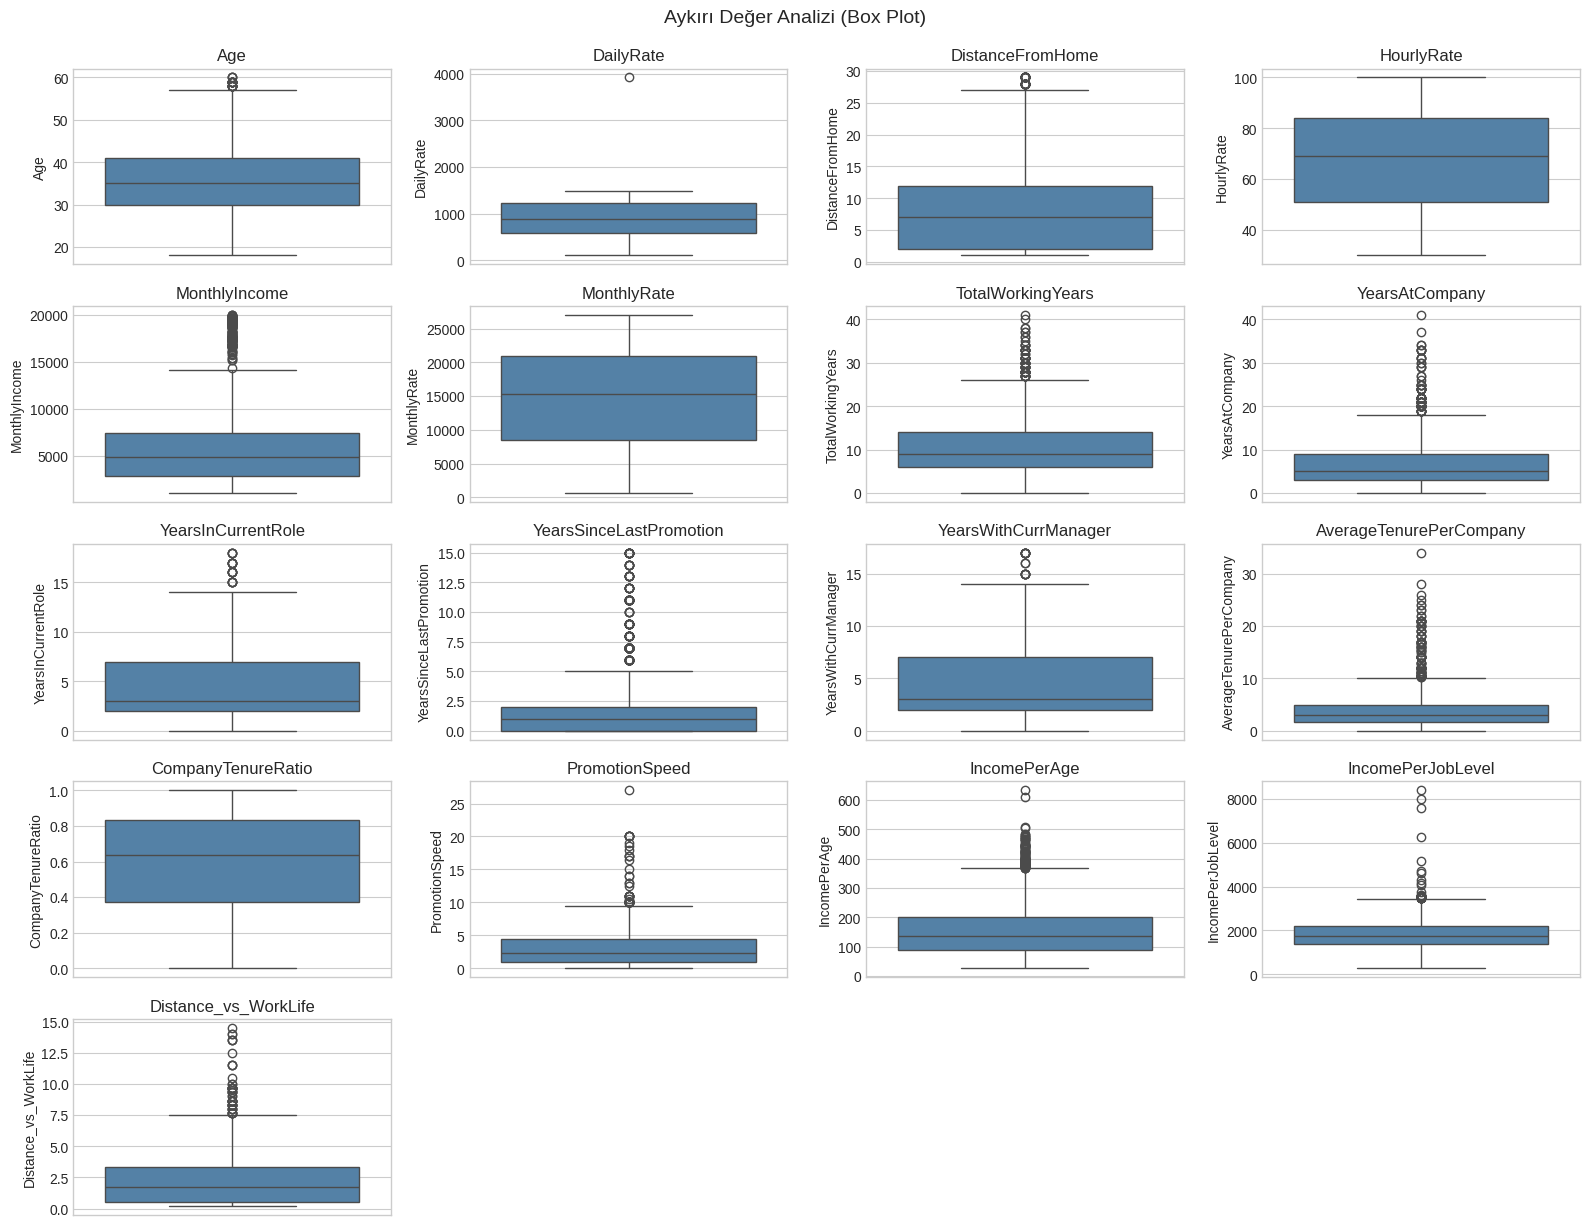

In [14]:
fig, axes = plt.subplots(5, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=X_train[col], ax=axes[i], color='steelblue')
    axes[i].set_title(col)

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle('Aykırı Değer Analizi (Box Plot)', y=1.02, fontsize=14)
plt.show()

In [15]:
# Outlier Baskılama (IQR * 3 ile)
def cap_outliers(df_train, df_test, columns, multiplier=3):
    """
    Train setinden hesaplanan sınırlarla hem train hem test setindeki 
    aykırı değerleri baskılar (cap).
    """
    outlier_info = {}
    
    for col in columns:
        Q1 = df_train[col].quantile(0.05)
        Q3 = df_train[col].quantile(0.95)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Train seti için outlier sayısı
        train_outliers_low = (df_train[col] < lower_bound).sum()
        train_outliers_high = (df_train[col] > upper_bound).sum()
        
        # Test seti için outlier sayısı
        test_outliers_low = (df_test[col] < lower_bound).sum()
        test_outliers_high = (df_test[col] > upper_bound).sum()
        
        # Baskılama uygula
        df_train[col] = df_train[col].clip(lower=lower_bound, upper=upper_bound)
        df_test[col] = df_test[col].clip(lower=lower_bound, upper=upper_bound)
        
        total_outliers = train_outliers_low + train_outliers_high
        if total_outliers > 0:
            outlier_info[col] = {
                'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
                'lower': lower_bound, 'upper': upper_bound,
                'train_capped': total_outliers,
                'test_capped': test_outliers_low + test_outliers_high
            }
    
    return df_train, df_test, outlier_info

# Uygula
X_train, X_test, outlier_summary = cap_outliers(X_train, X_test, numeric_cols, multiplier=3)

# Sonuçları göster
print("Outlier Baskılama Özeti (IQR * 3):")
print("="*70)
for col, info in outlier_summary.items():
    print(f"{col:30} | Lower: {info['lower']:>10.2f} | Upper: {info['upper']:>10.2f} | Train: {info['train_capped']:>4} | Test: {info['test_capped']:>4}")

print(f"\n{'='*70}")
print(f"Toplam {len(outlier_summary)} kolonda outlier baskılandı.")

Outlier Baskılama Özeti (IQR * 3):

Toplam 0 kolonda outlier baskılandı.


In [16]:
cols_to_log = [
    'AverageTenurePerCompany', 'PromotionSpeed', 'YearsSinceLastPromotion', 
    'YearsAtCompany', 'IncomePerJobLevel', 'MonthlyIncome', 
    'Distance_vs_WorkLife', 'IncomePerAge', 'TotalWorkingYears', 'DistanceFromHome'
]

In [17]:
# Log dönüşümü uygula
for col in cols_to_log:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

print(f"Log1p dönüşümü uygulanan kolonlar ({len(cols_to_log)} adet):")
for col in cols_to_log:
    print(f"  ✓ {col}")

Log1p dönüşümü uygulanan kolonlar (10 adet):
  ✓ AverageTenurePerCompany
  ✓ PromotionSpeed
  ✓ YearsSinceLastPromotion
  ✓ YearsAtCompany
  ✓ IncomePerJobLevel
  ✓ MonthlyIncome
  ✓ Distance_vs_WorkLife
  ✓ IncomePerAge
  ✓ TotalWorkingYears
  ✓ DistanceFromHome


In [18]:
# Ordinal Encoding - Sadece object tipindeki kolonlar için
ordinal_encoder_cols = ["BusinessTravel", "OverTime"]

# BusinessTravel için özel sıralama
business_travel_order = ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']
X_train['BusinessTravel'] = X_train['BusinessTravel'].map({v: i for i, v in enumerate(business_travel_order)})
X_test['BusinessTravel'] = X_test['BusinessTravel'].map({v: i for i, v in enumerate(business_travel_order)})

# OverTime için binary encoding (No=0, Yes=1)
X_train['OverTime'] = X_train['OverTime'].map({'No': 0, 'Yes': 1})
X_test['OverTime'] = X_test['OverTime'].map({'No': 0, 'Yes': 1})

print("Ordinal Encoding uygulandı:")
print(f"  ✓ BusinessTravel: Non-Travel(0) < Travel_Rarely(1) < Travel_Frequently(2)")
print(f"  ✓ OverTime: No(0) < Yes(1)")

Ordinal Encoding uygulandı:
  ✓ BusinessTravel: Non-Travel(0) < Travel_Rarely(1) < Travel_Frequently(2)
  ✓ OverTime: No(0) < Yes(1)


In [19]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding
onehot_encoder_cols = ["Department", "EducationField", "JobRole", "MaritalStatus", "Gender"]

# Encoder oluştur
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Train seti üzerinde fit et ve transform yap
ohe_encoded_train = ohe.fit_transform(X_train[onehot_encoder_cols])
ohe_encoded_test = ohe.transform(X_test[onehot_encoder_cols])

# Yeni kolon isimlerini al
ohe_feature_names = ohe.get_feature_names_out(onehot_encoder_cols)

# DataFrame'e çevir
ohe_df_train = pd.DataFrame(ohe_encoded_train, columns=ohe_feature_names, index=X_train.index)
ohe_df_test = pd.DataFrame(ohe_encoded_test, columns=ohe_feature_names, index=X_test.index)

# Orijinal kolonları sil ve yenilerini ekle
X_train = X_train.drop(columns=onehot_encoder_cols).join(ohe_df_train)
X_test = X_test.drop(columns=onehot_encoder_cols).join(ohe_df_test)

print(f"One-Hot Encoding uygulandı: {onehot_encoder_cols}")
print(f"Oluşturulan yeni kolonlar: {len(ohe_feature_names)} adet")
print(f"DataFrame boyutu - Train: {X_train.shape}, Test: {X_test.shape}")

One-Hot Encoding uygulandı: ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender']
Oluşturulan yeni kolonlar: 18 adet
DataFrame boyutu - Train: (1677, 50), Test: (1119, 50)


In [20]:
# Yüksek korelasyonlu/VIF kolonları sil
cols_to_drop = ['DistanceFromHome', 'IncomePerAge', 'Department_Sales']

X_train.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)

# numeric_cols listesinden de çıkar
for col in cols_to_drop:
    if col in numeric_cols:
        numeric_cols.remove(col)

print(f"Silinen kolonlar: {cols_to_drop}")
print(f"Yeni DataFrame boyutu - Train: {X_train.shape}, Test: {X_test.shape}")

Silinen kolonlar: ['DistanceFromHome', 'IncomePerAge', 'Department_Sales']
Yeni DataFrame boyutu - Train: (1677, 47), Test: (1119, 47)


In [21]:
# IncomePerJobLevel kolonunu sil
X_train.drop(columns=['IncomePerJobLevel'], inplace=True)
X_test.drop(columns=['IncomePerJobLevel'], inplace=True)

# numeric_cols listesinden de çıkar
if 'IncomePerJobLevel' in numeric_cols:
    numeric_cols.remove('IncomePerJobLevel')

print("Silinen kolon: IncomePerJobLevel")
print(f"Yeni DataFrame boyutu - Train: {X_train.shape}, Test: {X_test.shape}")

Silinen kolon: IncomePerJobLevel
Yeni DataFrame boyutu - Train: (1677, 46), Test: (1119, 46)


In [22]:
# Yeni feature'lar ekle
X_train["Role_Stagnation_Ratio"] = X_train["YearsInCurrentRole"] / (X_train["YearsAtCompany"] + 1)
X_test["Role_Stagnation_Ratio"] = X_test["YearsInCurrentRole"] / (X_test["YearsAtCompany"] + 1)
numeric_cols.append("Role_Stagnation_Ratio")

X_train["Manager_Stability_Ratio"] = X_train["YearsWithCurrManager"] / (X_train["YearsAtCompany"] + 1)
X_test["Manager_Stability_Ratio"] = X_test["YearsWithCurrManager"] / (X_test["YearsAtCompany"] + 1)
numeric_cols.append("Manager_Stability_Ratio")

print("Yeni feature'lar eklendi:")
print(f"  ✓ Role_Stagnation_Ratio = YearsInCurrentRole / (YearsAtCompany + 1)")
print(f"  ✓ Manager_Stability_Ratio = YearsWithCurrManager / (YearsAtCompany + 1)")
print(f"\nDataFrame boyutu - Train: {X_train.shape}, Test: {X_test.shape}")

Yeni feature'lar eklendi:
  ✓ Role_Stagnation_Ratio = YearsInCurrentRole / (YearsAtCompany + 1)
  ✓ Manager_Stability_Ratio = YearsWithCurrManager / (YearsAtCompany + 1)

DataFrame boyutu - Train: (1677, 48), Test: (1119, 48)


In [23]:
# Yüksek VIF kolonlarını sil
cols_to_drop_vif = ['YearsWithCurrManager', "YearsInCurrentRole"]

X_train.drop(columns=cols_to_drop_vif, inplace=True)
X_test.drop(columns=cols_to_drop_vif, inplace=True)

# numeric_cols listesinden de çıkar
for col in cols_to_drop_vif:
    if col in numeric_cols:
        numeric_cols.remove(col)

print(f"Silinen kolonlar: {cols_to_drop_vif}")
print(f"Yeni DataFrame boyutu - Train: {X_train.shape}, Test: {X_test.shape}")

Silinen kolonlar: ['YearsWithCurrManager', 'YearsInCurrentRole']
Yeni DataFrame boyutu - Train: (1677, 46), Test: (1119, 46)


In [24]:
X_train

,id,Age,BusinessTravel,DailyRate,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,AverageTenurePerCompany,CompanyTenureRatio,PromotionSpeed,Distance_vs_WorkLife,Department_Research & Development,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Gender_Male,Role_Stagnation_Ratio,Manager_Stability_Ratio
0,0,36,2,599,3,4,42,3,1,4,7.8621,5099,1,1,13,3,2,1,2.3979,2,3,2.3979,2.0794,1.7918,0.9091,0.8109,1.9459,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,2.3544
1,1,35,1,921,3,1,46,3,1,1,7.9725,10778,1,0,17,3,4,1,1.6094,3,3,1.6094,0.0000,1.0986,0.8000,1.6094,1.0986,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.7664,1.1497
2,2,32,1,718,3,3,80,3,2,4,8.4399,16495,0,0,17,3,4,2,1.6094,3,3,1.3863,0.6931,1.6094,0.6000,0.9163,2.0149,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.8381,0.8381
3,3,38,1,1488,3,3,40,3,2,1,8.5845,13384,3,0,14,3,3,0,2.7726,1,1,1.9459,0.0000,1.5581,0.3750,1.9459,0.6931,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.6789
4,4,50,1,1017,4,2,37,3,5,1,9.8540,19805,1,1,13,3,3,0,3.4657,0,3,3.4657,1.6094,2.8034,0.9688,1.9741,0.8109,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,3.1350,2.2393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,1672,30,1,945,3,4,73,3,3,3,9.0737,14255,1,0,19,3,2,0,2.3979,2,4,2.3979,0.0000,1.7918,0.9091,2.3979,0.1823,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,2.3544
1673,1673,32,1,1303,3,1,48,3,1,2,8.1733,15972,4,0,19,3,4,1,2.3979,3,4,1.6094,0.6931,1.0986,0.3636,1.0986,0.3365,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.7664,1.1497
1674,1674,29,2,1184,3,2,36,2,1,1,7.9392,15322,1,1,11,3,3,0,0.6931,2,3,0.6931,0.0000,0.4055,0.5000,0.6931,1.9459,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
1675,1675,36,1,441,2,2,48,4,2,3,8.5954,4051,1,0,21,4,3,2,2.3979,3,2,2.3979,0.0000,1.7918,0.9091,2.3979,1.3863,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.8829,2.3544


In [25]:
import optuna
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

# Optuna loglarını biraz sessize alalım
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 1. Sabit Ayarlar
N_SPLITS = 5
RANDOM_STATE = 42
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Dengesizlik Oranı Hesaplama (scale_pos_weight için referans)
# Negatif Sınıf / Pozitif Sınıf
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Hesaplanan Sınıf Oranı (Negative/Positive): {ratio:.2f}")

# ==========================================
# 2. XGBoost İçin Optuna Objective Fonksiyonu
# ==========================================
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        
        # Kritik: Recall Sorununu Çözmek İçin Ağırlıklandırma
        # Optuna'nın bu oranı optimize etmesine izin veriyoruz
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, ratio * 1.5),
        
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': -1,
        'random_state': RANDOM_STATE,
        'tree_method': 'hist' # Hız için
    }
    
    model = xgb.XGBClassifier(**params)
    
    # Stratified K-Fold ile Cross Validation Skoru (ROC-AUC)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

# ==========================================
# 3. LightGBM İçin Optuna Objective Fonksiyonu
# ==========================================
def objective_lgbm(trial):
    params = {
        # --- BASİTLEŞTİRİLMİŞ ARAMA ALANI ---
        'n_estimators': trial.suggest_int('n_estimators', 100, 300), # 500 bile değil, 300 yeter
        'max_depth': trial.suggest_int('max_depth', 3, 7),           # Sığ ağaçlar
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2), # Biraz daha agresif öğrensin
        'num_leaves': trial.suggest_int('num_leaves', 20, 30),       # Çok az yaprak
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        
        # --- KRİTİK GÜVENLİK AYARLARI ---
        'n_jobs': 1,        # Paralel işlem YOK (Kilitlenmeyi önler)
        'device': 'cpu',    # Sadece CPU
        'verbose': -1,      # Sessiz mod
        
        # --- DENGESİZLİK AYARI ---
        # ratio değişkeninin hesaplandığından emin ol, yoksa 10 yaz geç
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        
        'objective': 'binary',
        'metric': 'auc'
    }
        
    model = lgb.LGBMClassifier(**params)
    
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

# ==========================================
# 4. Optimizasyonu Başlat (XGBoost)
# ==========================================
print("XGBoost Optimizasyonu Başlıyor...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20) # Deneme sayısını artırabilirsin (Örn: 50)
print(f"En iyi XGBoost Parametreleri: {study_xgb.best_params}")
print(f"En iyi XGBoost CV Skoru: {study_xgb.best_value:.4f}")

# ==========================================
# 5. Optimizasyonu Başlat (LightGBM)
# ==========================================
print("\nLightGBM Optimizasyonu Başlıyor...")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=20) # Deneme sayısını artırabilirsin
print(f"En iyi LightGBM Parametreleri: {study_lgbm.best_params}")
print(f"En iyi LightGBM CV Skoru: {study_lgbm.best_value:.4f}")

# ==========================================
# 6. Final Modelleri Eğitme ve Ensemble
# ==========================================
print("\nFinal Modeller Eğitiliyor...")

# En iyi parametreleri alıp modelleri tekrar kuruyoruz
best_xgb = xgb.XGBClassifier(**study_xgb.best_params, objective='binary:logistic', eval_metric='auc', random_state=RANDOM_STATE)
best_lgbm = lgb.LGBMClassifier(**study_lgbm.best_params, objective='binary', metric='auc', random_state=RANDOM_STATE, verbose=-1)

# Tüm train setiyle eğitim
best_xgb.fit(X_train, y_train)
best_lgbm.fit(X_train, y_train)

# Tahminleri Al (Olasılık olarak)
# [:, 1] diyerek pozitif sınıfın (1) olasılığını alıyoruz
probs_xgb = best_xgb.predict_proba(X_test)[:, 1]
probs_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# Ensemble: Basit Ortalamasını Alıyoruz
ensemble_preds = (probs_xgb + probs_lgbm) / 2

# Olasılıkları 0/1 sınıfına çevirmek için Eşik Değeri (Threshold)
# Dengeli olması için 0.5 yerine, Recall'u artırmak istersek bu eşiği düşürebiliriz (Örn: 0.4)
final_predictions = (ensemble_preds > 0.5).astype(int)

Hesaplanan Sınıf Oranı (Negative/Positive): 7.38
XGBoost Optimizasyonu Başlıyor...
En iyi XGBoost Parametreleri: {'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.009815316885578221, 'subsample': 0.5793899708778969, 'colsample_bytree': 0.6156024806909322, 'gamma': 4.213701477812312, 'min_child_weight': 10, 'scale_pos_weight': 7.538712245418196}
En iyi XGBoost CV Skoru: 0.8330

LightGBM Optimizasyonu Başlıyor...
En iyi LightGBM Parametreleri: {'n_estimators': 240, 'max_depth': 3, 'learning_rate': 0.05293457436131589, 'num_leaves': 25, 'min_child_samples': 48, 'scale_pos_weight': 5.089125048148072}
En iyi LightGBM CV Skoru: 0.8244

Final Modeller Eğitiliyor...


In [26]:
import os

# 1. ADIM: ID'lerin olduğu orijinal dosyayı bulup okuyoruz.
# Kaggle'da genellikle veri seti "/kaggle/input/" altında durur.
# Eğer klasör ismini tam hatırlamıyorsan aşağıdaki kod otomatik bulmaya çalışır:

try:
    # Genelde kullanılan standart yollar
    test_file_path = '/kaggle/input/playground-series-s4e1/test.csv'
    df_test_orijinal = pd.read_csv(test_file_path)
    print(f"Dosya şuradan okundu: {test_file_path}")
except FileNotFoundError:
    # Eğer yukarıdaki yol yanlışsa, sample_submission dosyasını arayalım
    print("Test dosyası standart yolda bulunamadı, alternatif aranıyor...")
    # Bu kısım klasördeki csv dosyalarını listeler, oradan doğru ismi görebilirsin
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            if 'test.csv' in filename or 'sample_submission.csv' in filename:
                test_file_path = os.path.join(dirname, filename)
    
    # Bulunan yoldan okuma
    df_test_orijinal = pd.read_csv(test_file_path)

# 2. ADIM: Boyut Kontrolü (Hayati Önemli)
# Orijinal dosyadaki satır sayısı ile senin tahmin sayın EŞİT OLMALI.
print(f"\nOrijinal Test Verisi Satır Sayısı: {len(df_test_orijinal)}")
print(f"Senin Tahmin (ensemble_preds) Sayın: {len(ensemble_preds)}")

if len(df_test_orijinal) == len(ensemble_preds):
    print("✅ Harika! Satır sayıları eşleşiyor.")
    
    # 3. ADIM: Submission DataFrame'ini oluşturma
    my_submission = pd.DataFrame({
        'id': df_test_orijinal['id'],  # ID'yi orijinal dosyadan alıyoruz
        'Attrition': ensemble_preds    # Tahmini senin modelden alıyoruz (Olasılık olarak)
    })

    # 4. ADIM: CSV olarak kaydetme
    my_submission.to_csv('submission_xgboost_lgbm_ensemble.csv', index=False)
    
    print("\nDosya başarıyla kaydedildi: 'submission_xgboost_lgbm_ensemble.csv'")
    print("İlk 5 satır önizlemesi:")
    print(my_submission.head())

else:
    print("❌ HATA: Satır sayıları tutmuyor! X_test oluştururken veri kaybı olmuş olabilir.")

Test dosyası standart yolda bulunamadı, alternatif aranıyor...
/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv

Orijinal Test Verisi Satır Sayısı: 1119
Senin Tahmin (ensemble_preds) Sayın: 1119
✅ Harika! Satır sayıları eşleşiyor.

Dosya başarıyla kaydedildi: 'submission_xgboost_lgbm_ensemble.csv'
İlk 5 satır önizlemesi:
     id  Attrition
0  1677     0.3195
1  1678     0.1435
2  1679     0.0676
3  1680     0.1083
4  1681     0.7822
